## Price Prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
np.random.seed(42)

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, CategoricalNB
from lightgbm import LGBMClassifier

In [3]:
df = pd.read_csv("mobil_data.csv")
df.head()

,BataryaGucu,Bluetooth,MikroislemciHizi,CiftHat,OnKameraMP,4G,DahiliBellek,Kalinlik,Agirlik,CekirdekSayisi,ArkaKameraMP,CozunurlukYükseklik,CozunurlukGenislik,RAM,BataryaOmru,3G,Dokunmatik,WiFi,FiyatAraligi,Renk
0,1325,Yok,"1,9",Yok,"2,0",Yok,50,"0,1",146,1,10,499,695,2328.0,2,Var,Yok,Yok,Normal,Beyaz
1,1046,Var,"2,8",Var,0.0,Var,58,"0,2",100,8,0,259,1040,3863.0,9,Var,Var,Var,Pahalı,Pembe
2,843,Yok,"1,3",Var,1.0,Yok,16,"0,9",119,7,4,593,732,1734.0,14,Yok,Yok,Var,Ucuz,Mor
3,894,Yok,"0,5",Var,"1,0",Var,50,"0,5",199,3,14,1285,1462,3615.0,6,Var,Yok,Var,Pahalı,Turuncu
4,936,Yok,"1,0",Yok,1.0,Yok,18,"0,2",153,3,18,1330,1686,2391.0,3,Var,Var,Var,Normal,Beyaz


In [4]:
df.shape

(2017, 20)

## Preprocessing

In [5]:
#fill the missing values with most frequent value for that feature
for feat in ["OnKameraMP", "RAM", "3G"]:
    df[feat] = df[feat].fillna(df[feat].mode()[0])

In [6]:
# replace "," with "." 
for feat in ["MikroislemciHizi", "OnKameraMP", "Kalinlik"]:
    df[feat] = df[feat].apply(lambda x: str(x).replace(",", "."))

In [7]:
#df.info()

In [8]:
#convert the features object to numeric
for feat in ["MikroislemciHizi", "OnKameraMP", "Kalinlik"]:
    df[feat] = pd.to_numeric(df[feat])

In [9]:
df["Bluetooth"] = df["Bluetooth"].replace({" ": "Yok"})

In [10]:
numeric_feats = df.select_dtypes(np.number).columns

In [11]:
from scipy.stats import zscore

mask_outliers = (abs(zscore(df[numeric_feats])) < 3).all(axis=1)

before_num = df.shape[0]
df = df[mask_outliers]
print("{} number of examples were dropped and new shape {}".format(before_num - df.shape[0], df.shape))

13 number of examples were dropped and new shape (2004, 20)


In [12]:
# convert nominal values to numeric using get_dummies method
df = pd.get_dummies(df, drop_first=True,
               columns=['Bluetooth', 'CiftHat', '4G', '3G', 'Dokunmatik', 'WiFi', 'Renk'])

In [13]:
df.FiyatAraligi.unique()

array(['Normal', 'Pahalı', 'Ucuz', 'Çok Ucuz'], dtype=object)

In [14]:
# the FiyatAraligi feature is an ordinal variable so I decided to convert it to numeric manually
target_labels = {"Çok Ucuz": 0, "Ucuz": 1, "Normal": 2, "Pahalı": 3}

df["FiyatAraligi"] = df["FiyatAraligi"].replace(target_labels)

In [15]:
#new feature
df["Cozunurluk"] = df["CozunurlukYükseklik"] * df["CozunurlukGenislik"]

There are not lots of features to do feature engineering. One of the most important features is the brand of a phone and the dataset does not contain that information. Instead of investing time to perform feature engineering, collecting data with the brand name would be more promising. If it is not possible to get access to the brand name(or any other business reasons to not use that feature), collecting more data and giving that data into a neural network would do the feature engineering job for us. For that dataset, I wouldn't prefer to do any of them because it is a toy dataset and the result of the classification is already good.

In [16]:
X = df.drop(["FiyatAraligi"], axis=1)
y = df["FiyatAraligi"]

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
print(X_train.shape, X_test.shape)

(1603, 30) (401, 30)


In [19]:
#I  chose to use MinMaxScaler because of the binary features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [20]:
X_train.head()

,BataryaGucu,MikroislemciHizi,OnKameraMP,DahiliBellek,Kalinlik,Agirlik,CekirdekSayisi,ArkaKameraMP,CozunurlukYükseklik,CozunurlukGenislik,...,Renk_Kırmızı,Renk_Mavi,Renk_Mor,Renk_Pembe,Renk_Sarı,Renk_Siyah,Renk_Turkuaz,Renk_Turuncu,Renk_Yeşil,Cozunurluk
0,0.462258,0.16,0.647059,0.387097,0.444444,0.716667,0.000000,1.0,0.372449,0.820427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.324774
1,0.525718,0.92,0.882353,0.774194,0.000000,0.341667,0.142857,1.0,0.600510,0.873832,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.547871
2,0.023380,0.76,0.705882,0.016129,0.222222,0.850000,0.857143,0.7,0.707143,0.693591,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.548864
3,0.895792,0.68,0.411765,0.870968,0.333333,0.825000,0.428571,0.5,0.399490,0.485314,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.247212
4,0.764863,0.72,0.470588,0.629032,0.111111,0.875000,0.142857,0.5,0.880102,0.955941,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.857550


## Model Selection

In [21]:
def train_models(models):
    scores = {}
    all_x = pd.concat([X_train, X_test])
    all_y = pd.concat([y_train, y_test])
    for model_name, model in models:
        score = cross_val_score(model, all_x, all_y)
        scores[model_name] = score
    scores_df = pd.DataFrame(scores).T
    scores_df["avg_score"] = scores_df.mean(axis=1)
        
    return scores_df

In [22]:
model_list = [("lr", LogisticRegression()),
              ("svm", SVC()),
              ("rf", RandomForestClassifier()),
              ("nb", MultinomialNB()),
              ("lgbm", LGBMClassifier()),
              ("nn", MLPClassifier([100, 100]))]

In [23]:
train_models(model_list)

,0,1,2,3,4,avg_score
lr,0.872818,0.882793,0.882793,0.902743,0.9100,0.890229
svm,0.835411,0.830424,0.835411,0.830424,0.8275,0.831834
rf,0.875312,0.865337,0.875312,0.855362,0.8600,0.866264
nb,NaN,NaN,NaN,NaN,0.5250,0.525000
lgbm,0.917706,0.900249,0.932668,0.890274,0.9125,0.910680
nn,0.882793,0.900249,0.877805,0.900249,0.8850,0.889219


- Logistic Regression -> Linear Model
- SVM -> Linear Model
- Random Forest -> Tree-based Model  (It can capture Linear/Non-Linear relationships)
- Light GBM -> Tree-based Model      (It can capture Linear/Non-Linear relationships)
- Naive Bayes -> Probabilistic Model
- Multi Layer Perceptron -> Neural Network (It can capture Linear/Non-Linear relationships)

I would select a tree-based model in that situation. I usually prefer LGBM becuse it runs faster than other tree-based models.

## Feature Importance/Selection

In [24]:
from lightgbm import LGBMClassifier, plot_importance

clf = LGBMClassifier()
clf.fit(X_train, y_train)

LGBMClassifier()

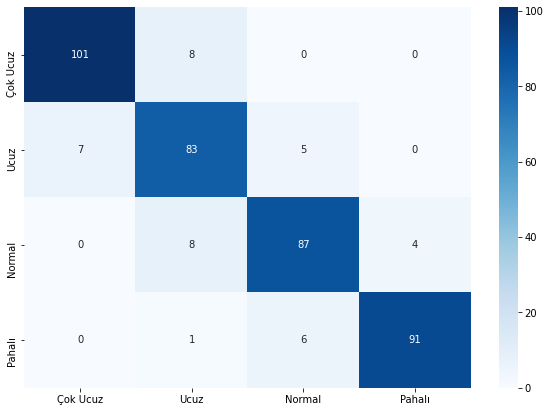

In [25]:
labels = ["Çok Ucuz", "Ucuz", "Normal", "Pahalı"]


preds = clf.predict(X_test)

plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, preds), 
            annot=True, cmap="Blues",  fmt="d",
            xticklabels=labels, yticklabels=labels);

In [26]:
print(classification_report(y_test, preds, target_names=labels))

              precision    recall  f1-score   support

    Çok Ucuz       0.94      0.93      0.93       109
        Ucuz       0.83      0.87      0.85        95
      Normal       0.89      0.88      0.88        99
      Pahalı       0.96      0.93      0.94        98

    accuracy                           0.90       401
   macro avg       0.90      0.90      0.90       401
weighted avg       0.90      0.90      0.90       401



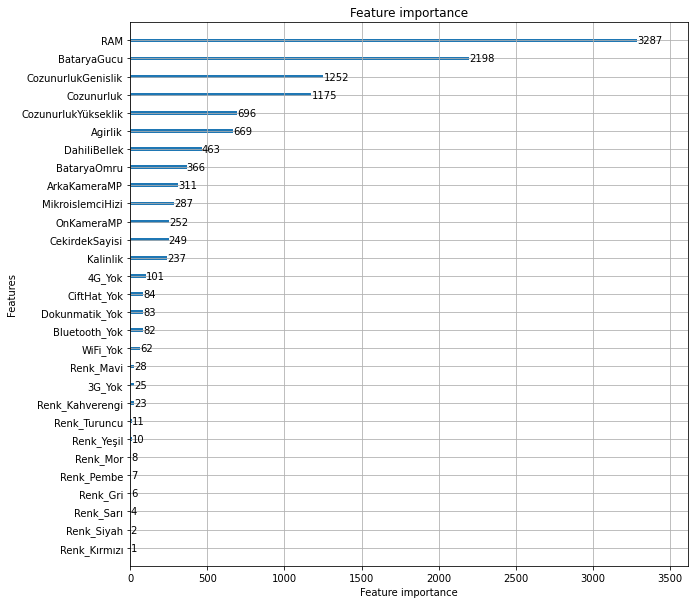

In [27]:
plot_importance(clf, figsize=(10, 10));

Using the first 101-15 features  a model can be trained again and if there is no significant performance drop, other features can be dropped. Of course there are more sophisticated methods for features selection but this could be the easiest way to select features.

The model gives a significant weight to the "BataryaGucu", "Agirlik", "BataryaOmru" and I think these features shouldn't be that much important. If I was building a real project about phone prices, I would drop or penilaze these features.

## Result

I didn't do hyperparameter optimization because I didn't have time enough time. Before all the steps, checking the data collecting process and being sure that the data are correct would be better for this dataset. The dataset does not contain lots of data so training a neural network isn't a good option. It has a good amount of categorical features and tree-based models are good at using categorical features. They are also fast both in training and testing.